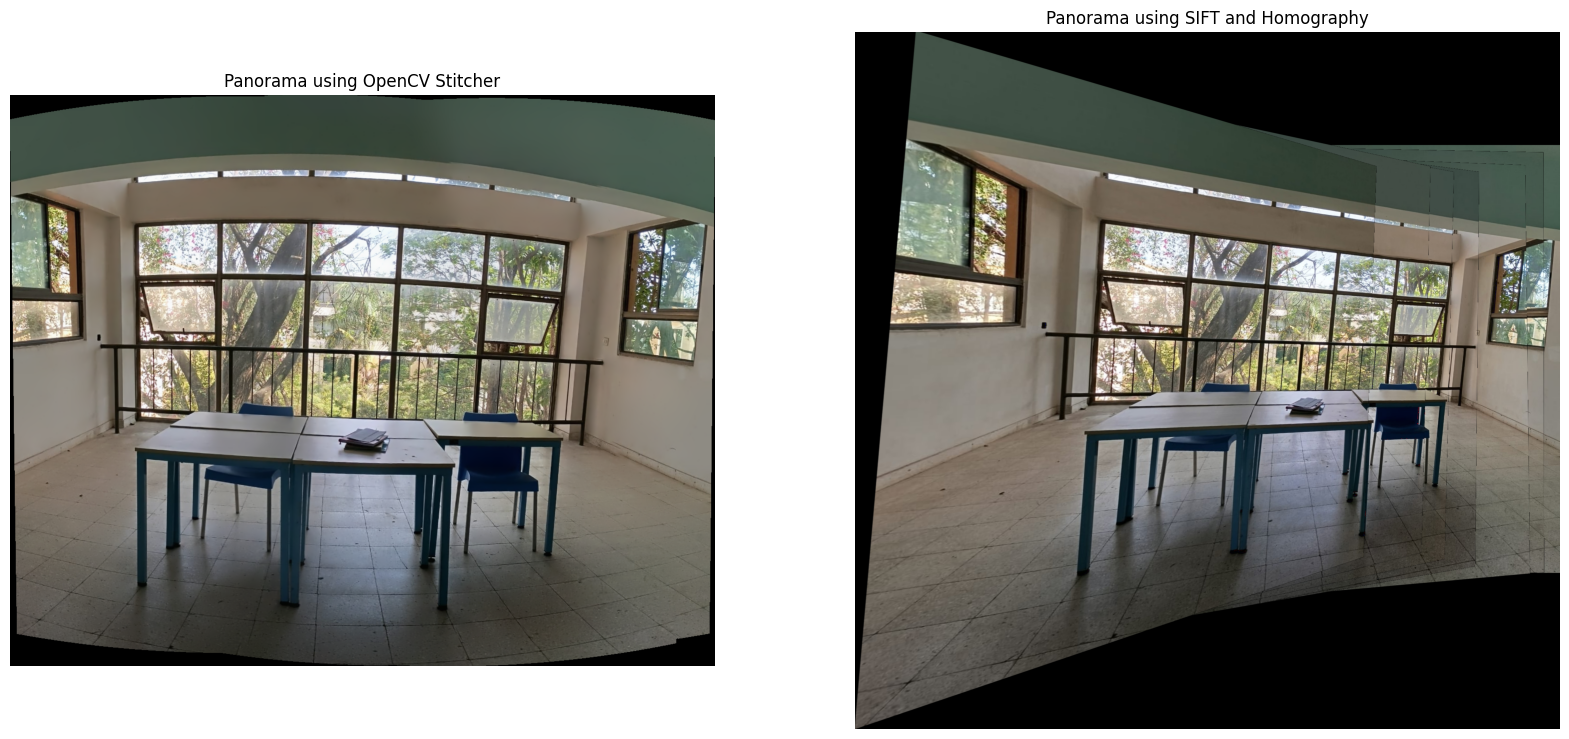

In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def load_images(image_paths):
    """
    Loads images from the provided list of file paths.
    Raises a ValueError if any image cannot be loaded.
    """
    images = [cv2.imread(path) for path in image_paths]
    if any(img is None for img in images):
        raise ValueError("Error: One or more images could not be loaded.")
    return images

def detect_and_match_features(img1, img2):
    """
    Detects SIFT keypoints and descriptors in both images, then matches them using BFMatcher.
    Returns the keypoints for both images and the best 50 matches.
    """
    sift = cv2.SIFT_create()
    keypoints1, descriptors1 = sift.detectAndCompute(img1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(img2, None)
    
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    matches = bf.match(descriptors1, descriptors2)
    matches = sorted(matches, key=lambda x: x.distance)
    return keypoints1, keypoints2, matches[:50]

def stitch_with_sift(images):
    """
    Iteratively stitches images using SIFT feature matching, homography estimation,
    and robust canvas creation to avoid broadcasting issues.
    """
    panorama = images[0]
    for i in range(1, len(images)):
        img1 = panorama
        img2 = images[i]
        
        # Detect and match features between the current panorama and the next image
        keypoints1, keypoints2, matches = detect_and_match_features(img1, img2)
        
        # Compute homography (transform img2 to img1 coordinate space)
        src_pts = np.float32([keypoints2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([keypoints1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
        H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        
        # Get dimensions of both images
        h1, w1 = img1.shape[:2]
        h2, w2 = img2.shape[:2]
        
        # Compute the corners of img2 after warping
        corners_img2 = np.float32([[0,0], [0,h2], [w2,h2], [w2,0]]).reshape(-1, 1, 2)
        transformed_corners = cv2.perspectiveTransform(corners_img2, H)
        
        # Get the corners of img1
        corners_img1 = np.float32([[0,0], [0,h1], [w1,h1], [w1,0]]).reshape(-1, 1, 2)
        
        # Combine all corners to find the extents of the new panorama
        all_corners = np.concatenate((corners_img1, transformed_corners), axis=0)
        [xmin, ymin] = np.int32(all_corners.min(axis=0).ravel())
        [xmax, ymax] = np.int32(all_corners.max(axis=0).ravel())
        
        # Create a translation matrix if any coordinates are negative
        translation = np.array([[1, 0, -xmin],
                                [0, 1, -ymin],
                                [0, 0, 1]])
        
        # Determine new canvas size
        new_width = xmax - xmin
        new_height = ymax - ymin
        
        # Warp img2 into the new canvas coordinate system
        warped_img2 = cv2.warpPerspective(img2, translation.dot(H), (new_width, new_height))
        
        # Create a canvas and place img1 onto it
        panorama_canvas = np.zeros((new_height, new_width, 3), dtype=img1.dtype)
        panorama_canvas[-ymin:h1 - ymin, -xmin:w1 - xmin] = img1
        
        # Overlay warped img2 onto the canvas (simple overlay, blending can be added)
        mask = (warped_img2 > 0)
        panorama_canvas[mask] = warped_img2[mask]
        
        # Update the panorama for the next iteration
        panorama = panorama_canvas
        
    return panorama

def main():
    # List of 7 image file paths (adjust paths if necessary)
    image_paths = ["Images/1.jpeg", "Images/2.jpeg", "Images/3.jpeg",
                   "Images/4.jpeg", "Images/5.jpeg", "Images/6.jpeg", "Images/7.jpeg"]
    
    try:
        images = load_images(image_paths)
    except ValueError as e:
        print(e)
        return
    
    # ----------------------------
    # Version 1: OpenCV Stitcher
    # ----------------------------
    stitcher = cv2.Stitcher_create()
    status, stitched_opencv = stitcher.stitch(images)
    if status != cv2.Stitcher_OK:
        print("Stitching with OpenCV Stitcher failed! Error code:", status)
        return
    
    # ----------------------------
    # Version 2: SIFT + Homography Stitching
    # ----------------------------
    stitched_sift = stitch_with_sift(images)
    
    # Convert both panoramas from BGR to RGB for display
    stitched_opencv_rgb = cv2.cvtColor(stitched_opencv, cv2.COLOR_BGR2RGB)
    stitched_sift_rgb = cv2.cvtColor(stitched_sift, cv2.COLOR_BGR2RGB)
    
    # Display the two panoramas side by side
    plt.figure(figsize=(20, 10))
    
    plt.subplot(1, 2, 1)
    plt.imshow(stitched_opencv_rgb)
    plt.title("Panorama using OpenCV Stitcher")
    plt.axis("off")
    
    plt.subplot(1, 2, 2)
    plt.imshow(stitched_sift_rgb)
    plt.title("Panorama using SIFT and Homography")
    plt.axis("off")
    
    plt.show()

if __name__ == "__main__":
    main()
